In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0., alpha_2=0., T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x/1000, y/1000, z
    

In [3]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)


In [4]:
u = U[:,:,0]
v = V[:,:,0]

def moca1(n_ic, n_jc, r=14):

    u1 = u[n_ic-r:n_ic+r+1, n_jc]
    v1 = v[n_ic-r:n_ic+r+1, n_jc]
    dx = x[1] - x[0]
    xx = x[n_ic-r:n_ic+r+1]
    yy = [y[n_jc]] * len(xx)
    l = xx - xx[0]
    coefficients = np.polyfit(l, v1, 1)
    c, b = coefficients
    a = np.polyfit(l, u1, 0)
    x0 = - b / c
    y0 = a / c
    x0 += xx[0]
    y0 += yy[0]

    return x0, y0, l, xx, yy, u1, v1, a, b, c

n_ic = 50
n_jc = 60

n_ic2 = 50
n_jc2 = 54

n_ic3 = 50
n_jc3 = 66

x0, y0, l, xx, yy, u1, v1, a, b, c = moca1(n_ic, n_jc)

x02, y02, l2, xx2, yy2, u2, v2, a2, b2, c2  = moca1(n_ic2, n_jc2)
x03, y03, l3, xx3, yy3, u3, v3, a3, b3, c3  = moca1(n_ic3, n_jc3)

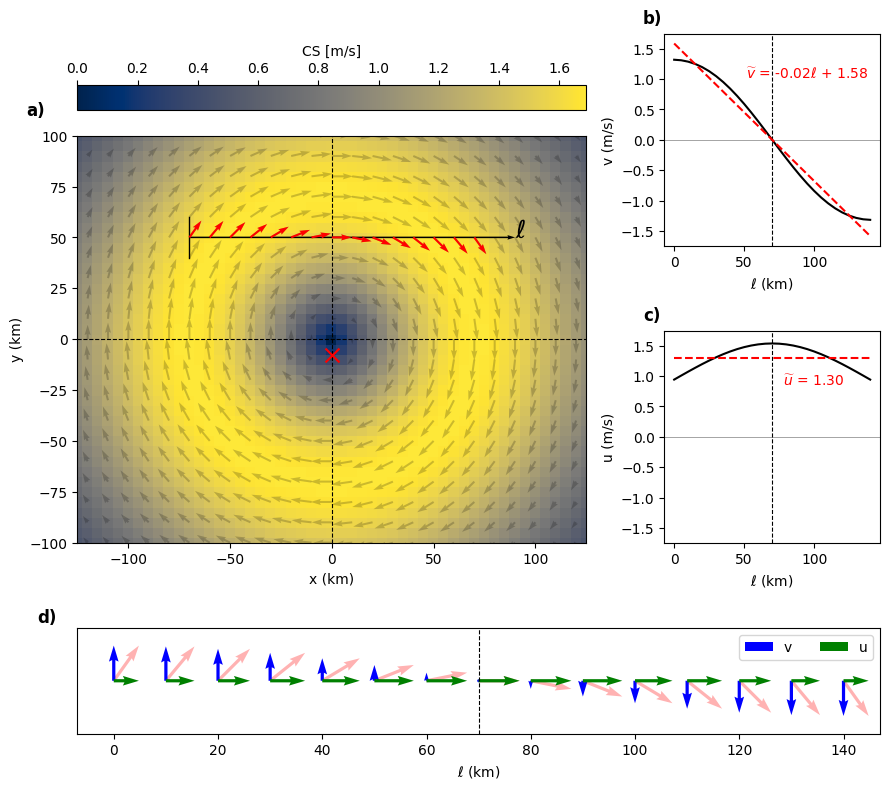

xc=0.0, yc=[-7.61412232], a=[1.30266544], b=1.5827123135842465, c=-0.022610175908346377


In [5]:

import matplotlib.gridspec as gridspec

# GridSpec for custom layout
fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 0.5])  # Add extra row with smaller height

# Main 2x3 plot
ax_main = fig.add_subplot(gs[:2, :2])
pc = ax_main.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)  # Horizontal grid line at y=0
ax_main.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)  # Vertical grid line at x=0

spacing = 2
scale = 40
width = 0.004
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main.scatter(x0, y0, color='r', marker='x', s=100, label='MOCA Result', zorder=4)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')

# Other transects
alpha = .7
# # closest
# ax_main.quiver(xx2[::spacing], yy2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
# ax_main.scatter(x02, y02, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
# # furthest
# ax_main.quiver(xx3[::spacing], yy3[::spacing], u3[::spacing], v3[::spacing], scale=scale, width=width, color='c', zorder=3, alpha=alpha)
# ax_main.scatter(x03, y03, color='c', marker='x', s=70, zorder=3, alpha=alpha)

# l axis
ax_main.quiver(xx[0], yy[0], xx[-1] - xx[0] + 20, yy[-1] - yy[0], angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=1)
ax_main.plot([xx[0], xx[0]], [yy[0] - 10, yy[0] + 10], color='k', linewidth=1)
ax_main.text(xx[-1] + 20, yy[0], r'$\ell$', fontsize=18)

ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')
ax_main.text(-0.1, 1.05, 'a)', transform=ax_main.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])

coeffs_v = np.polyfit(l, v1, 1)
fit_line_v = np.poly1d(coeffs_v)
ax2.axvline(l[len(l)//2], color='black', linewidth=0.8, linestyle='--', zorder=2)

# ax2.quiver(l[::spacing], [0] * len(l[::spacing]), [0] * len(v1[::spacing]), v1[::spacing],
#                  width=width, color=colors[0], alpha=1, label='v', scale=scale, scale_units='xy')

ax2.plot(l, v1, color='k')
ax2.plot(l, fit_line_v(l), linestyle="--", color='r')
ax2.set_xlabel(r'$\ell$ (km)')
ax2.set_ylabel('v (m/s)')
ax2.text(0.38, 0.85, fr"$\widetilde{{v}}$ = {coeffs_v[0]:.2f}$\ell$ + {coeffs_v[1]:.2f}", transform=ax2.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax2.text(-0.1, 1.05, 'b)', transform=ax2.transAxes, fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)

coeffs_u = np.polyfit(l, u1, 0)
fit_line_u = np.poly1d(coeffs_u)
ax3.axvline(l[len(l)//2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3.plot(l, u1, color='k')
ax3.plot(l, fit_line_u(l), linestyle="--", color='r')
ax3.set_xlabel(r'$\ell$ (km)')
ax3.set_ylabel('u (m/s)')
ax3.text(0.55, 0.80, fr"$\widetilde{{u}}$ = {coeffs_u[0]:.2f}", transform=ax3.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax3.text(-0.1, 1.05, 'c)', transform=ax3.transAxes, fontsize=12, fontweight='bold')
ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)

ymin1, ymax1 = ax2.get_ylim()
ymin2, ymax2 = ax3.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2.set_ylim(ymin, ymax)
ax3.set_ylim(ymin, ymax)

# Add 1x3 plot at the bottom
ax_bottom = fig.add_subplot(gs[2, :])
alpha = 0.3
width = 0.004
scale = 30
colors = ['b', 'g']

ax_bottom.axvline(l[len(l)//2], color='black', linewidth=0.8, linestyle='--', zorder=2)

ax_bottom.quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], v1[::spacing],
                 width=width, alpha=alpha, color='r', scale=scale)
ax_bottom.quiver(l[::spacing], [0] * len(l[::spacing]), [0] * len(v1[::spacing]), v1[::spacing],
                 width=width, color=colors[0], alpha=1, label='v', scale=scale)
ax_bottom.quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], [0] * len(u1[::spacing]),
                 width=width, color=colors[1], alpha=1, label='u', scale=scale)


ax_bottom.set_xlabel(r'$\ell$ (km)')
ax_bottom.yaxis.set_ticks([])
ax_bottom.yaxis.set_tick_params(length=0)
ax_bottom.set_yticklabels([])
ax_bottom.legend(loc='upper right', ncol=3)
ax_bottom.text(-0.05, 1.05, 'd)', transform=ax_bottom.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
print(f'xc={x0}, yc={y0}, a={a}, b={b}, c={c}')

In [6]:
def moca1(n_ic, n_jc, r=14):

    u1 = u[n_ic-r:n_ic+r+1, n_jc]
    v1 = v[n_ic-r:n_ic+r+1, n_jc]
    dx = x[1] - x[0]
    xx = x[n_ic-r:n_ic+r+1]
    yy = [y[n_jc]] * len(xx)
    l = xx - xx[0]
    coefficients = np.polyfit(l, v1, 1)
    c, b = coefficients
    a = np.polyfit(l, u1, 0)
    x0 = - b / c
    y0 = a / c
    x0 += xx[0]
    y0 += yy[0]

    return x0, y0, l, xx, yy, u1, v1, a, b, c

n_ic = 50
n_jc = 60

n_ic2 = 50
n_jc2 = 54
r2 = 8

n_ic3 = 50
n_jc3 = 66
r3 = 20

x0, y0, l, xx, yy, u1, v1, a, b, c = moca1(n_ic, n_jc)

x02, y02, l2, xx2, yy2, u2, v2, a2, b2, c2  = moca1(n_ic2, n_jc2)
x03, y03, l3, xx3, yy3, u3, v3, a3, b3, c3  = moca1(n_ic3, n_jc3)

x02_r, y02_r, l2_r, xx2_r, yy2_r, u2_r, v2_r, a2_r, b2_r, c2_r  = moca1(n_ic, n_jc, r2)
x03_r, y03_r, l3_r, xx3_r, yy3_r, u3_r, v3_r, a3_r, b3_r, c3_r  = moca1(n_ic, n_jc, r3)




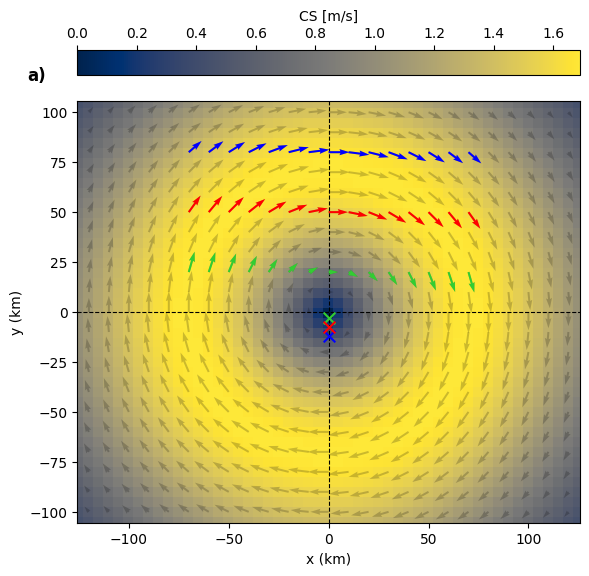

In [7]:
# Create a new figure for ax_main
fig, ax_main = plt.subplots(figsize=(6, 6))

# Main plot
pc = ax_main.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 40
width = 0.004
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')

# Other transects
alpha = 1
ax_main.quiver(xx2[::spacing], yy2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
ax_main.scatter(x02, y02, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)

ax_main.quiver(xx3[::spacing], yy3[::spacing], u3[::spacing], v3[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main.scatter(x03, y03, color='b', marker='x', s=70, zorder=3, alpha=alpha)

ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')
ax_main.text(-0.1, 1.05, 'a)', transform=ax_main.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


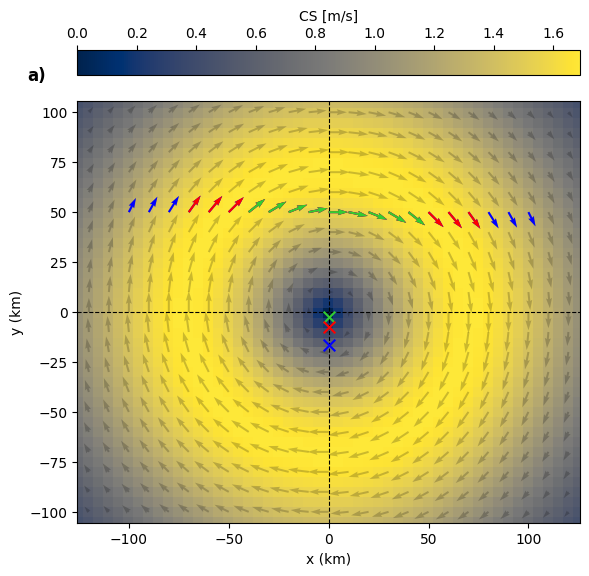

In [8]:
# Create a new figure for ax_main
fig, ax_main = plt.subplots(figsize=(6, 6))

# Main plot
pc = ax_main.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 40
width = 0.004
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=4)
ax_main.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')

# Other transects
alpha = 1
ax_main.quiver(xx2_r[::spacing], yy2_r[::spacing], u2_r[::spacing], v2_r[::spacing], scale=scale, width=width, color='limegreen', zorder=5, alpha=alpha)
ax_main.scatter(x02_r, y02_r, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)

ax_main.quiver(xx3_r[::spacing], yy3_r[::spacing], u3_r[::spacing], v3_r[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main.scatter(x03_r, y03_r, color='b', marker='x', s=70, zorder=3, alpha=alpha)

ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')
ax_main.text(-0.1, 1.05, 'a)', transform=ax_main.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


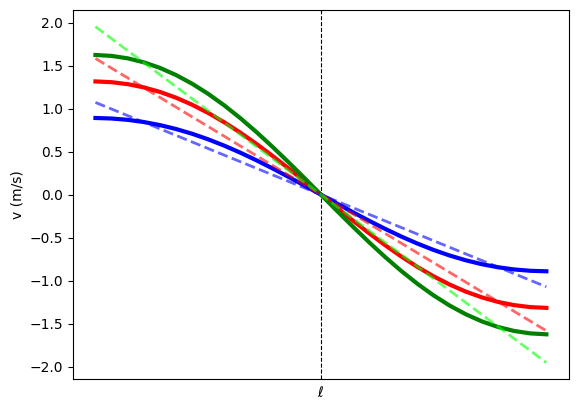

In [9]:
# plt.figure(figsize=(10, 6))
d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2, 1))
plt.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
plt.plot(d1, v3, color="b", linewidth=3)
plt.plot(d2, v1, color="r", linewidth=3)
plt.plot(d3, v2, color="g", linewidth=3)
plt.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
plt.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
plt.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
plt.ylabel('v (m/s)')
plt.xlabel(r'$\ell$')
plt.xticks([])
plt.show()

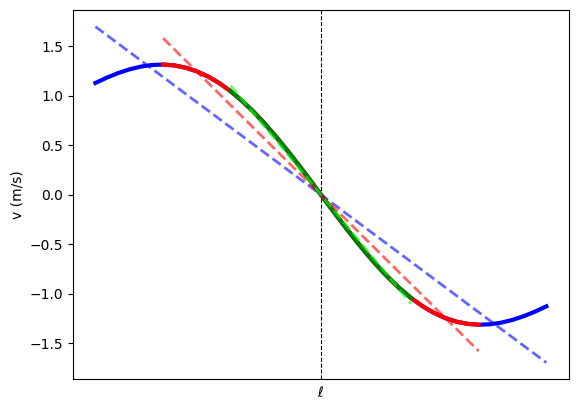

In [10]:
# plt.figure(figsize=(10, 6))
d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]

fit1 = np.poly1d(np.polyfit(d1, v3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2_r, 1))
plt.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
plt.plot(d1, v3_r, color="b", linewidth=3)
plt.plot(d2, v1, color="r", linewidth=3)
plt.plot(d3, v2_r, color="g", linewidth=3)
plt.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
plt.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
plt.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
plt.ylabel('v (m/s)')
plt.xlabel(r'$\ell$')
plt.xticks([])
plt.show()


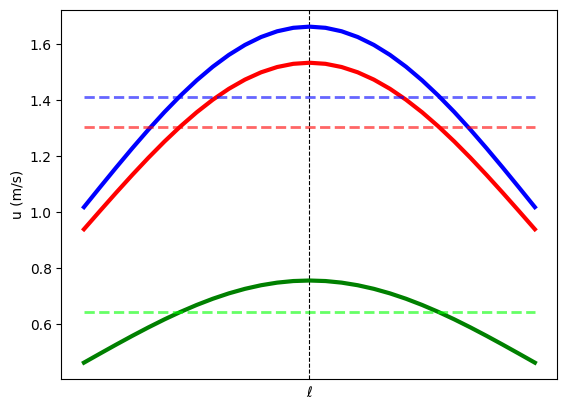

In [11]:
# plt.figure(figsize=(10, 6))
d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3, 1))
fit2 = np.poly1d(np.polyfit(d2, u1, 1))
fit3 = np.poly1d(np.polyfit(d3, u2, 1))
plt.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
plt.plot(d1, u3, color="b", linewidth=3)
plt.plot(d2, u1, color="r", linewidth=3)
plt.plot(d3, u2, color="g", linewidth=3)
plt.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
plt.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
plt.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
plt.ylabel('u (m/s)')
plt.xlabel(r'$\ell$')
plt.xticks([])
plt.show()


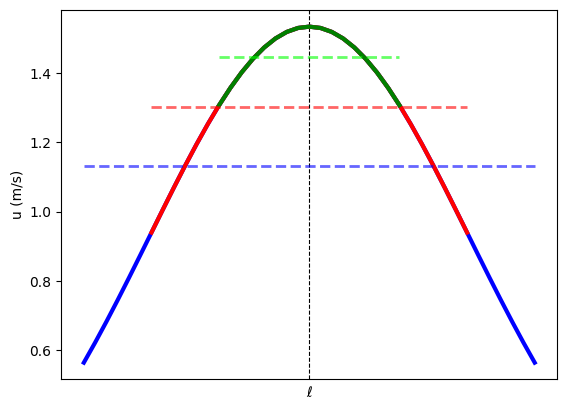

In [12]:
# plt.figure(figsize=(10, 6))




d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, u1, 1))
fit3 = np.poly1d(np.polyfit(d3, u2_r, 1))
plt.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
plt.plot(d1, u3_r, color="b", linewidth=3)
plt.plot(d2, u1, color="r", linewidth=3)
plt.plot(d3, u2_r, color="g", linewidth=3)
plt.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
plt.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
plt.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
plt.ylabel('u (m/s)')
plt.xlabel(r'$\ell$')
plt.xticks([])
plt.show()

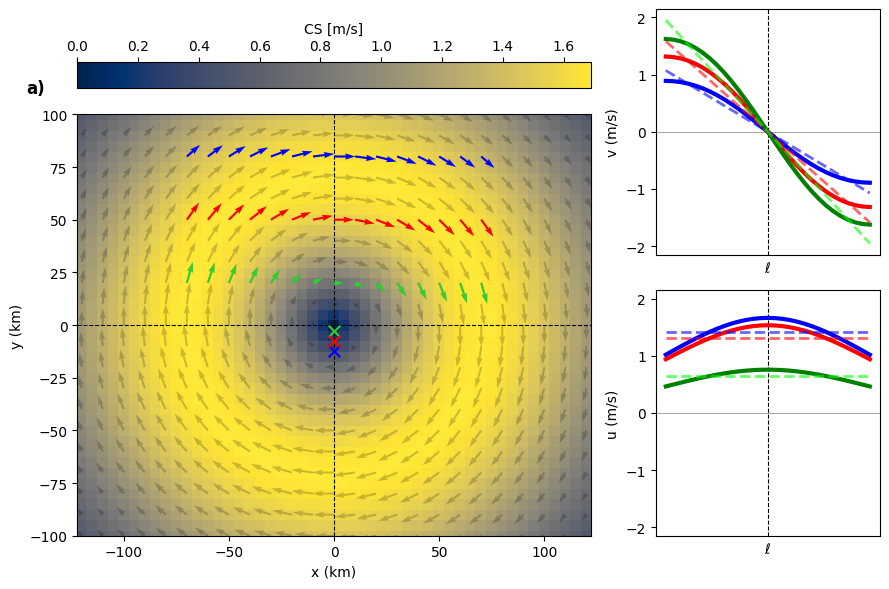

xc=0.0, yc=[-7.61412232], a=0, b=2.0904352901536347, c=-0.029863361287909097


In [24]:
# GridSpec for custom layout (Removed third row)
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 1])

# Main 2x3 plot
ax_main = fig.add_subplot(gs[:, :2])
pc = ax_main.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 40
width = 0.004
alpha = 1
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main.quiver(xx2[::spacing], yy2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
ax_main.scatter(x02, y02, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
ax_main.quiver(xx3[::spacing], yy3[::spacing], u3[::spacing], v3[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main.scatter(x03, y03, color='b', marker='x', s=70, zorder=3, alpha=alpha)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')

ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')
ax_main.text(-0.1, 1.05, 'a)', transform=ax_main.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])

d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2, 1))
ax2.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2.plot(d1, v3, color="b", linewidth=3)
ax2.plot(d2, v1, color="r", linewidth=3)
ax2.plot(d3, v2, color="g", linewidth=3)
ax2.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
ax2.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
ax2.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
ax2.set_ylabel('v (m/s)')
ax2.set_xlabel(r'$\ell$')
ax2.set_xticks([])

d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3, 1))
fit2 = np.poly1d(np.polyfit(d2, u1, 1))
fit3 = np.poly1d(np.polyfit(d3, u2, 1))
ax3.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3.plot(d1, u3, color="b", linewidth=3)
ax3.plot(d2, u1, color="r", linewidth=3)
ax3.plot(d3, u2, color="g", linewidth=3)
ax3.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
ax3.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
ax3.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
ax3.set_ylabel('u (m/s)')
ax3.set_xlabel(r'$\ell$')
ax3.set_xticks([])

ymin1, ymax1 = ax2.get_ylim()
ymin2, ymax2 = ax3.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2.set_ylim(ymin, ymax)
ax3.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()
print(f'xc={x0}, yc={y0}, a={a}, b={b}, c={c}')



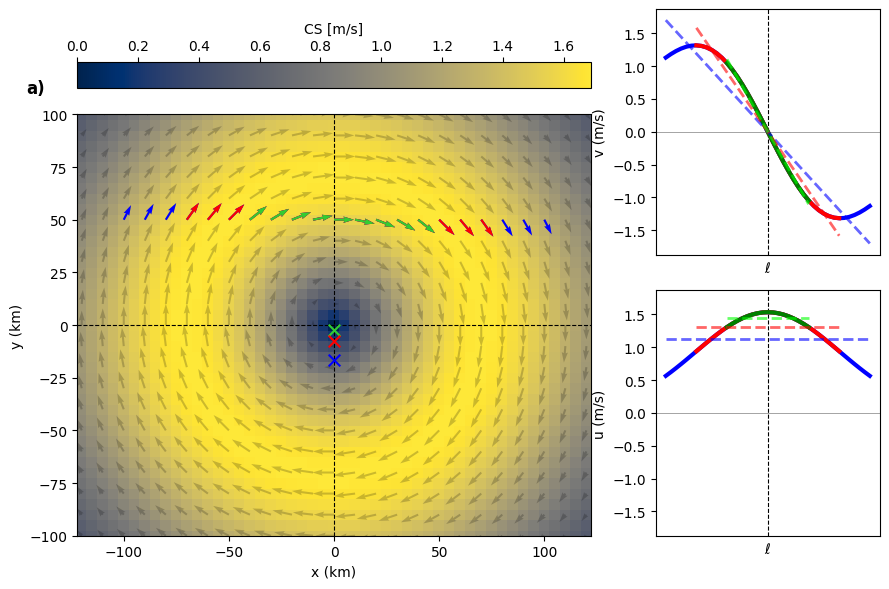

xc=0.0, yc=[-7.61412232], a=0, b=2.0904352901536347, c=-0.029863361287909097


In [29]:
# GridSpec for custom layout (Removed third row)
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 1])

# Main 2x3 plot
ax_main = fig.add_subplot(gs[:, :2])
pc = ax_main.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 40
width = 0.004
alpha = 1
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx3_r[::spacing], yy3_r[::spacing], u3_r[::spacing], v3_r[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main.scatter(x03_r, y03_r, color='b', marker='x', s=70, zorder=3, alpha=alpha)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main.quiver(xx2_r[::spacing], yy2_r[::spacing], u2_r[::spacing], v2_r[::spacing], scale=scale, width=width, color='limegreen', zorder=5, alpha=alpha)
ax_main.scatter(x02_r, y02_r, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)

plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')

ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')
ax_main.text(-0.1, 1.05, 'a)', transform=ax_main.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])

d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2_r, 1))
ax2.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2.plot(d1, v3_r, color="b", linewidth=3)
ax2.plot(d2, v1, color="r", linewidth=3)
ax2.plot(d3, v2_r, color="g", linewidth=3)
ax2.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
ax2.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
ax2.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
ax2.set_ylabel('v (m/s)')
ax2.set_xlabel(r'$\ell$')
ax2.set_xticks([])

d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, u1, 1))
fit3 = np.poly1d(np.polyfit(d3, u2_r, 1))
ax3.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3.plot(d1, u3_r, color="b", linewidth=3)
ax3.plot(d2, u1, color="r", linewidth=3)
ax3.plot(d3, u2_r, color="g", linewidth=3)
ax3.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
ax3.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
ax3.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
ax3.set_ylabel('u (m/s)')
ax3.set_xlabel(r'$\ell$')
ax3.set_xticks([])

ymin1, ymax1 = ax2.get_ylim()
ymin2, ymax2 = ax3.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2.set_ylim(ymin, ymax)
ax3.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()
print(f'xc={x0}, yc={y0}, a={a}, b={b}, c={c}')

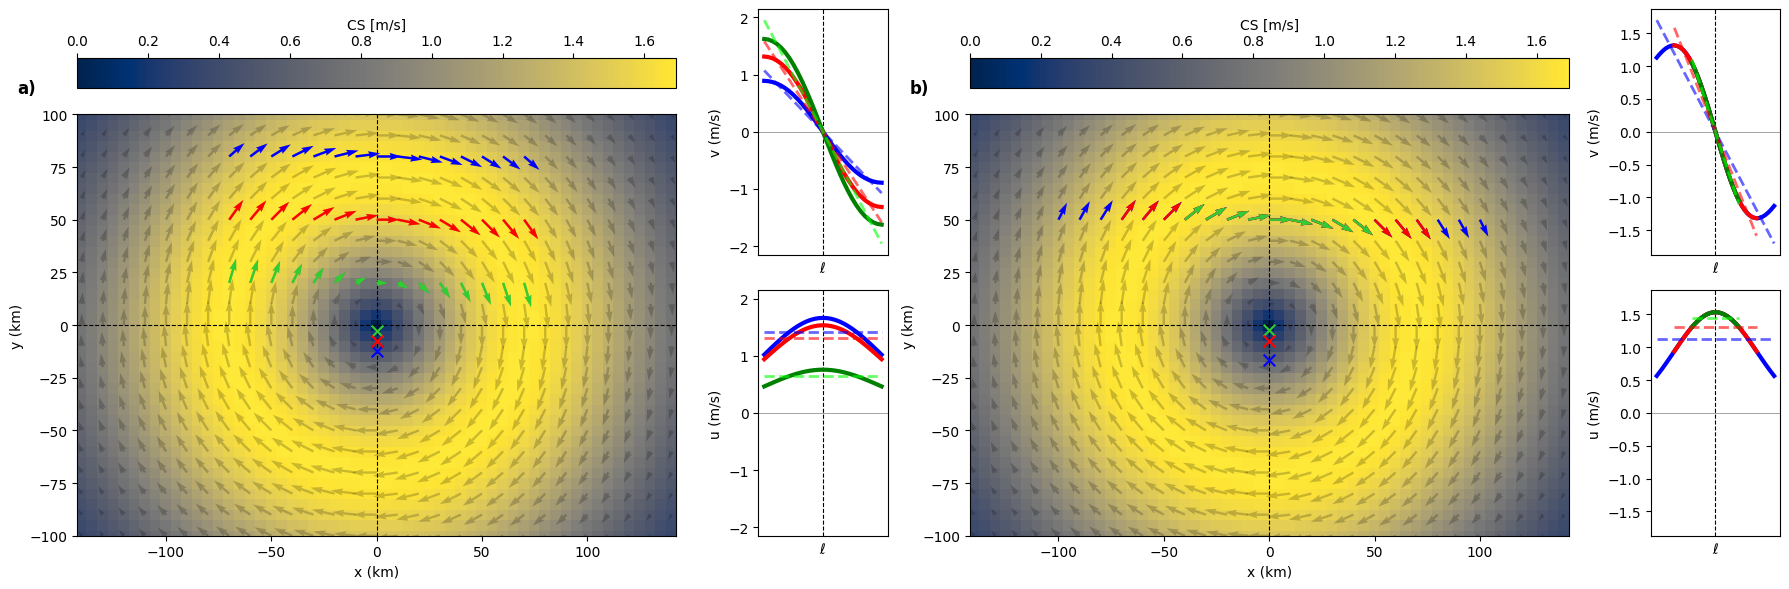

In [35]:
# Combined Plot: Left and Right Side by Side

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 6, figure=fig, width_ratios=[2, 2, 1, 2, 2, 1])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pc = ax_main_left.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main_left.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_left.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 40
width = 0.004
alpha = 1
ax_main_left.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main_left.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main_left.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main_left.quiver(xx2[::spacing], yy2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
ax_main_left.scatter(x02, y02, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
ax_main_left.quiver(xx3[::spacing], yy3[::spacing], u3[::spacing], v3[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main_left.scatter(x03, y03, color='b', marker='x', s=70, zorder=3, alpha=alpha)
plt.colorbar(pc, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')

ax_main_left.axis('equal')
ax_main_left.set_xlim(-100, 100)
ax_main_left.set_ylim(-100, 100)
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.text(-0.1, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2, 1))
ax2_left.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.plot(d1, v3, color="b", linewidth=3)
ax2_left.plot(d2, v1, color="r", linewidth=3)
ax2_left.plot(d3, v2, color="g", linewidth=3)
ax2_left.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
ax2_left.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
ax2_left.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
ax2_left.set_ylabel('v (m/s)')
ax2_left.set_xlabel(r'$\ell$')
ax2_left.set_xticks([])

d1, d2, d3 = l3 + xx3[0] - xx[0], l, l2 + xx2[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3, 1))
fit2 = np.poly1d(np.polyfit(d2, u1, 1))
fit3 = np.poly1d(np.polyfit(d3, u2, 1))
ax3_left.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.plot(d1, u3, color="b", linewidth=3)
ax3_left.plot(d2, u1, color="r", linewidth=3)
ax3_left.plot(d3, u2, color="g", linewidth=3)
ax3_left.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
ax3_left.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
ax3_left.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
ax3_left.set_ylabel('u (m/s)')
ax3_left.set_xlabel(r'$\ell$')
ax3_left.set_xticks([])

ymin1, ymax1 = ax2_left.get_ylim()
ymin2, ymax2 = ax3_left.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2_left.set_ylim(ymin, ymax)
ax3_left.set_ylim(ymin, ymax)

# RIGHT PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 3:5])
pc = ax_main_right.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main_right.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_right.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

ax_main_right.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main_right.quiver(xx3_r[::spacing], yy3_r[::spacing], u3_r[::spacing], v3_r[::spacing], scale=scale, width=width, color='b', zorder=3, alpha=alpha)
ax_main_right.scatter(x03_r, y03_r, color='b', marker='x', s=70, zorder=3, alpha=alpha)
ax_main_right.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main_right.scatter(x0, y0, color='r', marker='x', s=70, label='MOCA Result', zorder=4)
ax_main_right.quiver(xx2_r[::spacing], yy2_r[::spacing], u2_r[::spacing], v2_r[::spacing], scale=scale, width=width, color='limegreen', zorder=5, alpha=alpha)
ax_main_right.scatter(x02_r, y02_r, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)

plt.colorbar(pc, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')

ax_main_right.axis('equal')
ax_main_right.set_xlim(-100, 100)
ax_main_right.set_ylim(-100, 100)
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.text(-0.1, 1.05, 'b)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, v3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, v1, 1))
fit3 = np.poly1d(np.polyfit(d3, v2_r, 1))
ax2_right.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.plot(d1, v3_r, color="b", linewidth=3)
ax2_right.plot(d2, v1, color="r", linewidth=3)
ax2_right.plot(d3, v2_r, color="g", linewidth=3)
ax2_right.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
ax2_right.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
ax2_right.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
ax2_right.set_ylabel('v (m/s)')
ax2_right.set_xlabel(r'$\ell$')
ax2_right.set_xticks([])

d1, d2, d3 = l3_r + xx3_r[0] - xx[0], l, l2_r + xx2_r[0] - xx[0]
fit1 = np.poly1d(np.polyfit(d1, u3_r, 1))
fit2 = np.poly1d(np.polyfit(d2, u1, 1))
fit3 = np.poly1d(np.polyfit(d3, u2_r, 1))
ax3_right.axvline(d1[len(d1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.plot(d1, u3_r, color="b", linewidth=3)
ax3_right.plot(d2, u1, color="r", linewidth=3)
ax3_right.plot(d3, u2_r, color="g", linewidth=3)
ax3_right.plot(d1, fit1(d1), color=(0, 0, 1, 0.6), linestyle='--', linewidth=2)  # Light blue for fit1
ax3_right.plot(d2, fit2(d2), color=(1, 0, 0, 0.6), linestyle='--', linewidth=2)  # Light red for fit2
ax3_right.plot(d3, fit3(d3), color=(0, 1, 0, 0.6), linestyle='--', linewidth=2)  # Light green for fit3
ax3_right.set_ylabel('u (m/s)')
ax3_right.set_xlabel(r'$\ell$')
ax3_right.set_xticks([])

ymin1, ymax1 = ax2.get_ylim()
ymin2, ymax2 = ax3.get_ylim()

ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

ax2_right.set_ylim(ymin, ymax)
ax3_right.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


## Improved version

In [14]:
def fit_cubic_and_tangent(x, y):
    # Fit a third-degree polynomial (cubic) to the data
    coeffs = np.polyfit(x, y, 3)
    # Create a polynomial object from the coefficients
    cubic = np.poly1d(coeffs)
    # Find the derivative of the cubic (tangent)
    cubic_deriv = np.polyder(cubic)
    # Find the roots of the cubic (where the polynomial crosses y = 0)
    x_tangent = np.roots(cubic)
    # Filter the roots to only keep those within the x-domain
    x_tangent_real = x_tangent[np.isreal(x_tangent) & (x_tangent >= min(x)) & (x_tangent <= max(x))].real
    if len(x_tangent_real) > 0:
        # Use the first real root in the domain
        root = x_tangent_real[0]
        tangent_slope = cubic_deriv(root)
        tangent_intercept = -tangent_slope * root
    else:
        y_ans = np.sign(y[np.argmax(np.abs(y))]) * np.max(np.abs(y))
        return 0, y_ans, 0  # Return 0 for tangent if no root

    # Tangent line equation: y = mx + c, with m = tangent_slope and c = tangent_intercept
    tangent_line = tangent_slope * x + tangent_intercept

    # Calculate R^2 (coefficient of determination) for the cubic fit
    y_fit = cubic(x)
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    return tangent_slope, tangent_intercept, r_squared

0.0 [-7.61412232]
1.4210854715202004e-14 [-3.03758514]
0.0 [-12.2425161]


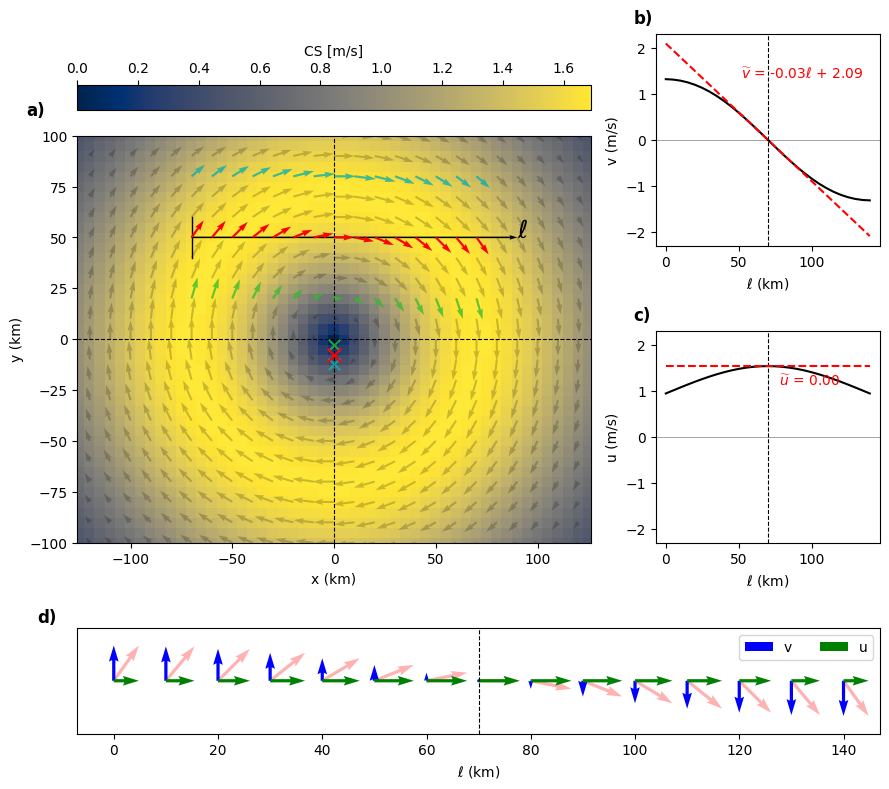

In [15]:
# NEW CUBIC TANGENT FIT

import matplotlib.gridspec as gridspec

# GridSpec for custom layout
fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 0.5])  # Add extra row with smaller height

# Main 2x3 plot
ax_main = fig.add_subplot(gs[:2, :2])
pc = ax_main.pcolor(x, y, np.hypot(u, v), cmap='cividis')
ax_main.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)  # Horizontal grid line at y=0
ax_main.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)  # Vertical grid line at x=0

spacing = 2
scale = 40
width = 0.004
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)
ax_main.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color='r', zorder=3)
ax_main.scatter(x0, y0, color='r', marker='x', s=100, label='MOCA Result', zorder=4)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
print(x0, y0)
# Other transects
alpha = .7
# closest
ax_main.quiver(xx2[::spacing], yy2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width, color='limegreen', zorder=3, alpha=alpha)
ax_main.scatter(x02, y02, color='limegreen', marker='x', s=70, zorder=3, alpha=alpha)
print(x02, y02)
# furthest
ax_main.quiver(xx3[::spacing], yy3[::spacing], u3[::spacing], v3[::spacing], scale=scale, width=width, color='c', zorder=3, alpha=alpha)
ax_main.scatter(x03, y03, color='c', marker='x', s=70, zorder=3, alpha=alpha)
print(x03, y03)

# l axis
ax_main.quiver(xx[0], yy[0], xx[-1] - xx[0] + 20, yy[-1] - yy[0], angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=1)
ax_main.plot([xx[0], xx[0]], [yy[0] - 10, yy[0] + 10], color='k', linewidth=1)
ax_main.text(xx[-1] + 20, yy[0], r'$\ell$', fontsize=18)

ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')
ax_main.text(-0.1, 1.05, 'a)', transform=ax_main.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])

# coeffs_v = np.polyfit(l, v1, 1)
c, b, r2 = fit_cubic_and_tangent(l, v1)
coeffs_v = (c, b)
fit_line_v = np.poly1d(coeffs_v)
ax2.axvline(l[len(l)//2], color='black', linewidth=0.8, linestyle='--', zorder=2)

# ax2.quiver(l[::spacing], [0] * len(l[::spacing]), [0] * len(v1[::spacing]), v1[::spacing],
#                  width=width, color=colors[0], alpha=1, label='v', scale=scale, scale_units='xy')

ax2.plot(l, v1, color='k')
ax2.plot(l, fit_line_v(l), linestyle="--", color='r')
ax2.set_xlabel(r'$\ell$ (km)')
ax2.set_ylabel('v (m/s)')
ax2.text(0.38, 0.85, fr"$\widetilde{{v}}$ = {coeffs_v[0]:.2f}$\ell$ + {coeffs_v[1]:.2f}", transform=ax2.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax2.text(-0.1, 1.05, 'b)', transform=ax2.transAxes, fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ymin, ymax = ax2.get_ylim()

# coeffs_u = np.polyfit(l, u1, 0)
a, d, r2 = fit_cubic_and_tangent(l, u1)
coeffs_u = (a, d)
fit_line_u = np.poly1d(coeffs_u)
ax3.axvline(l[len(l)//2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3.plot(l, u1, color='k')
ax3.plot(l, fit_line_u(l), linestyle="--", color='r')
ax3.set_xlabel(r'$\ell$ (km)')
ax3.set_ylabel('u (m/s)')
ax3.text(0.55, 0.80, fr"$\widetilde{{u}}$ = {coeffs_u[0]:.2f}", transform=ax3.transAxes,
         fontsize=10, verticalalignment='top', color='r')
ax3.text(-0.1, 1.05, 'c)', transform=ax3.transAxes, fontsize=12, fontweight='bold')
ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3.set_ylim(ymin, ymax)

# Add 1x3 plot at the bottom
ax_bottom = fig.add_subplot(gs[2, :])
alpha = 0.3
width = 0.004
scale = 30
colors = ['b', 'g']

ax_bottom.axvline(l[len(l)//2], color='black', linewidth=0.8, linestyle='--', zorder=2)

ax_bottom.quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], v1[::spacing],
                 width=width, alpha=alpha, color='r', scale=scale)
ax_bottom.quiver(l[::spacing], [0] * len(l[::spacing]), [0] * len(v1[::spacing]), v1[::spacing],
                 width=width, color=colors[0], alpha=1, label='v', scale=scale)
ax_bottom.quiver(l[::spacing], [0] * len(l[::spacing]), u1[::spacing], [0] * len(u1[::spacing]),
                 width=width, color=colors[1], alpha=1, label='u', scale=scale)


ax_bottom.set_xlabel(r'$\ell$ (km)')
ax_bottom.yaxis.set_ticks([])
ax_bottom.yaxis.set_tick_params(length=0)
ax_bottom.set_yticklabels([])
ax_bottom.legend(loc='upper right', ncol=3)
ax_bottom.text(-0.05, 1.05, 'd)', transform=ax_bottom.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

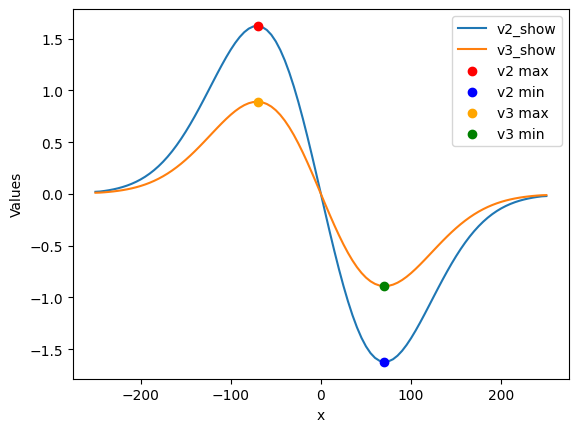

In [16]:
u2_show = u[:, n_jc2]
v2_show = v[:, n_jc2]

u3_show = u[:, n_jc3]
v3_show = v[:, n_jc3]

# Calculate maximum and minimum values and their indices
v2_max_idx, v2_min_idx = v2_show.argmax(), v2_show.argmin()
v3_max_idx, v3_min_idx = v3_show.argmax(), v3_show.argmin()

# Create the plot
plt.plot(x, v2_show, label="v2_show")
plt.plot(x, v3_show, label="v3_show")

# Mark the maximum and minimum points for v2_show
plt.scatter(x[v2_max_idx], v2_show[v2_max_idx], color="red", label="v2 max", zorder=5)
plt.scatter(x[v2_min_idx], v2_show[v2_min_idx], color="blue", label="v2 min", zorder=5)

# Mark the maximum and minimum points for v3_show
plt.scatter(x[v3_max_idx], v3_show[v3_max_idx], color="orange", label="v3 max", zorder=5)
plt.scatter(x[v3_min_idx], v3_show[v3_min_idx], color="green", label="v3 min", zorder=5)

# Add labels and legend
plt.xlabel("x")
plt.ylabel("Values")
plt.legend()
plt.show()
